# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 500
# scheduler_patience_mapping = {"CIFAR10": 200, "CIFAR100": 200, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 90
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_128_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.4892, 0.4803, 0.4392])
Shape of y: torch.Size([128]) torch.int64


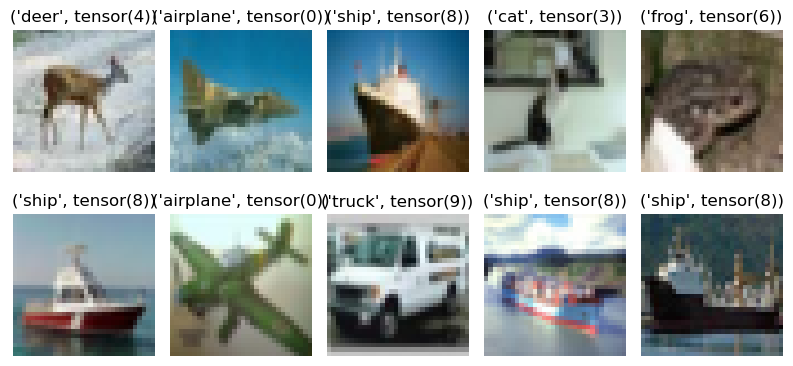

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     patience=scheduler_patience_mapping[DATASET],
#     factor=0.1,
#     verbose=True,
#     threshold=1e-4,
#     cooldown=100,
# )

scheduler = MultiStepLR(optimizer, milestones=[91, 137], gamma=0.1)
#
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/500] :


100%|██████████| 352/352 [00:24<00:00, 14.58it/s]

Train Loss: 0.0065 | Train Acc: 12.50%


Valid Loss: 2.3080 | Valid Acc: 9.64%
Test  Loss: 2.3040 | Test Acc: 10.23%
updated best eval loss : 2.308036357164383
--------------------------------------------------
[Epoch 2/500] :


100%|██████████| 352/352 [00:22<00:00, 15.96it/s]


Train Loss: 0.0064 | Train Acc: 18.06%
Valid Loss: 2.2993 | Valid Acc: 10.86%
Test  Loss: 2.2848 | Test Acc: 12.16%
updated best eval loss : 2.2993336617946625
--------------------------------------------------
[Epoch 3/500] :


100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Train Loss: 0.0063 | Train Acc: 20.83%
Valid Loss: 2.2177 | Valid Acc: 14.88%
Test  Loss: 2.2252 | Test Acc: 14.17%
updated best eval loss : 2.217658442258835
--------------------------------------------------
[Epoch 4/500] :


100%|██████████| 352/352 [00:21<00:00, 16.14it/s]


Train Loss: 0.0058 | Train Acc: 31.94%
Valid Loss: 1.9710 | Valid Acc: 26.22%
Test  Loss: 1.8125 | Test Acc: 31.50%
updated best eval loss : 1.9709621042013168
--------------------------------------------------
[Epoch 5/500] :


100%|██████████| 352/352 [00:21<00:00, 16.62it/s]


Train Loss: 0.0051 | Train Acc: 34.72%
Valid Loss: 1.8106 | Valid Acc: 33.32%
Test  Loss: 1.5028 | Test Acc: 43.66%
updated best eval loss : 1.8105671286582947
--------------------------------------------------
[Epoch 6/500] :


100%|██████████| 352/352 [00:21<00:00, 16.09it/s]


Train Loss: 0.0043 | Train Acc: 48.61%
Valid Loss: 1.6970 | Valid Acc: 39.30%
Test  Loss: 1.4453 | Test Acc: 48.37%
updated best eval loss : 1.6969672471284867
--------------------------------------------------
[Epoch 7/500] :


100%|██████████| 352/352 [00:22<00:00, 15.71it/s]


Train Loss: 0.0047 | Train Acc: 41.67%
Valid Loss: 1.4518 | Valid Acc: 48.78%
Test  Loss: 1.1659 | Test Acc: 58.63%
updated best eval loss : 1.451777419447899
--------------------------------------------------
[Epoch 8/500] :


100%|██████████| 352/352 [00:21<00:00, 16.49it/s]


Train Loss: 0.0038 | Train Acc: 50.00%
Valid Loss: 1.3869 | Valid Acc: 51.08%
Test  Loss: 1.1229 | Test Acc: 60.24%
updated best eval loss : 1.3869036078453063
--------------------------------------------------
[Epoch 9/500] :


100%|██████████| 352/352 [00:21<00:00, 16.22it/s]


Train Loss: 0.0035 | Train Acc: 56.94%
Valid Loss: 1.2909 | Valid Acc: 54.70%
Test  Loss: 1.0647 | Test Acc: 63.48%
updated best eval loss : 1.2908652007579804
--------------------------------------------------
[Epoch 10/500] :


100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Train Loss: 0.0032 | Train Acc: 58.33%
Valid Loss: 1.2169 | Valid Acc: 56.94%
Test  Loss: 0.9104 | Test Acc: 68.54%
updated best eval loss : 1.2169173568487168
--------------------------------------------------
[Epoch 11/500] :


100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Train Loss: 0.0032 | Train Acc: 62.50%
Valid Loss: 1.1477 | Valid Acc: 59.58%
Test  Loss: 0.8850 | Test Acc: 69.78%
updated best eval loss : 1.1476729944348336
--------------------------------------------------
[Epoch 12/500] :


100%|██████████| 352/352 [00:21<00:00, 16.30it/s]


Train Loss: 0.0028 | Train Acc: 61.11%
Valid Loss: 1.2333 | Valid Acc: 58.42%
Test  Loss: 1.1268 | Test Acc: 63.36%
--------------------------------------------------
[Epoch 13/500] :


100%|██████████| 352/352 [00:21<00:00, 16.55it/s]


Train Loss: 0.0027 | Train Acc: 68.06%
Valid Loss: 1.0856 | Valid Acc: 61.84%
Test  Loss: 0.8050 | Test Acc: 72.86%
updated best eval loss : 1.085603043437004
--------------------------------------------------
[Epoch 14/500] :


100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Train Loss: 0.0027 | Train Acc: 70.83%
Valid Loss: 1.0403 | Valid Acc: 63.08%
Test  Loss: 0.8973 | Test Acc: 69.91%
updated best eval loss : 1.0402764081954956
--------------------------------------------------
[Epoch 15/500] :


100%|██████████| 352/352 [00:21<00:00, 16.22it/s]


Train Loss: 0.0031 | Train Acc: 72.22%
Valid Loss: 0.9330 | Valid Acc: 67.80%
Test  Loss: 0.6869 | Test Acc: 75.82%
updated best eval loss : 0.9330019935965538
--------------------------------------------------
[Epoch 16/500] :


100%|██████████| 352/352 [00:21<00:00, 16.17it/s]


Train Loss: 0.0027 | Train Acc: 69.44%
Valid Loss: 0.9770 | Valid Acc: 66.32%
Test  Loss: 0.7711 | Test Acc: 73.39%
--------------------------------------------------
[Epoch 17/500] :


100%|██████████| 352/352 [00:21<00:00, 16.13it/s]


Train Loss: 0.0028 | Train Acc: 61.11%
Valid Loss: 0.9504 | Valid Acc: 66.32%
Test  Loss: 0.7076 | Test Acc: 75.11%
--------------------------------------------------
[Epoch 18/500] :


100%|██████████| 352/352 [00:22<00:00, 15.96it/s]


Train Loss: 0.0023 | Train Acc: 72.22%
Valid Loss: 0.9515 | Valid Acc: 66.54%
Test  Loss: 0.6755 | Test Acc: 76.73%
--------------------------------------------------
[Epoch 19/500] :


100%|██████████| 352/352 [00:22<00:00, 15.56it/s]


Train Loss: 0.0022 | Train Acc: 73.61%
Valid Loss: 1.0058 | Valid Acc: 65.10%
Test  Loss: 0.7741 | Test Acc: 73.98%
--------------------------------------------------
[Epoch 20/500] :


100%|██████████| 352/352 [00:21<00:00, 16.28it/s]


Train Loss: 0.0024 | Train Acc: 68.06%
Valid Loss: 0.8995 | Valid Acc: 68.30%
Test  Loss: 0.6929 | Test Acc: 76.30%
updated best eval loss : 0.8994986787438393
--------------------------------------------------
[Epoch 21/500] :


100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Train Loss: 0.0026 | Train Acc: 77.78%
Valid Loss: 0.9406 | Valid Acc: 66.98%
Test  Loss: 0.6768 | Test Acc: 76.74%
--------------------------------------------------
[Epoch 22/500] :


100%|██████████| 352/352 [00:21<00:00, 16.14it/s]


Train Loss: 0.0027 | Train Acc: 70.83%
Valid Loss: 0.9960 | Valid Acc: 65.04%
Test  Loss: 0.7072 | Test Acc: 75.52%
--------------------------------------------------
[Epoch 23/500] :


100%|██████████| 352/352 [00:22<00:00, 15.63it/s]


Train Loss: 0.0032 | Train Acc: 59.72%
Valid Loss: 0.9412 | Valid Acc: 66.62%
Test  Loss: 0.7018 | Test Acc: 75.87%
--------------------------------------------------
[Epoch 24/500] :


100%|██████████| 352/352 [00:21<00:00, 16.38it/s]


Train Loss: 0.0019 | Train Acc: 79.17%
Valid Loss: 0.8629 | Valid Acc: 70.08%
Test  Loss: 0.6001 | Test Acc: 79.40%
updated best eval loss : 0.8629406541585922
--------------------------------------------------
[Epoch 25/500] :


100%|██████████| 352/352 [00:21<00:00, 16.46it/s]


Train Loss: 0.0023 | Train Acc: 76.39%
Valid Loss: 0.8633 | Valid Acc: 69.42%
Test  Loss: 0.6088 | Test Acc: 79.13%
--------------------------------------------------
[Epoch 26/500] :


100%|██████████| 352/352 [00:22<00:00, 15.78it/s]


Train Loss: 0.0027 | Train Acc: 73.61%
Valid Loss: 0.8693 | Valid Acc: 70.40%
Test  Loss: 0.5919 | Test Acc: 79.35%
--------------------------------------------------
[Epoch 27/500] :


100%|██████████| 352/352 [00:22<00:00, 15.47it/s]


Train Loss: 0.0024 | Train Acc: 70.83%
Valid Loss: 0.8291 | Valid Acc: 71.42%
Test  Loss: 0.5463 | Test Acc: 81.35%
updated best eval loss : 0.8291158497333526
--------------------------------------------------
[Epoch 28/500] :


100%|██████████| 352/352 [00:22<00:00, 15.82it/s]


Train Loss: 0.0023 | Train Acc: 69.44%
Valid Loss: 0.9920 | Valid Acc: 66.36%
Test  Loss: 0.6836 | Test Acc: 77.85%
--------------------------------------------------
[Epoch 29/500] :


100%|██████████| 352/352 [00:21<00:00, 16.15it/s]


Train Loss: 0.0018 | Train Acc: 81.94%
Valid Loss: 0.8095 | Valid Acc: 71.50%
Test  Loss: 0.5680 | Test Acc: 80.65%
updated best eval loss : 0.809475676715374
--------------------------------------------------
[Epoch 30/500] :


100%|██████████| 352/352 [00:22<00:00, 15.73it/s]


Train Loss: 0.0017 | Train Acc: 79.17%
Valid Loss: 0.9776 | Valid Acc: 66.36%
Test  Loss: 0.6977 | Test Acc: 77.16%
--------------------------------------------------
[Epoch 31/500] :


100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Train Loss: 0.0031 | Train Acc: 58.33%
Valid Loss: 0.7971 | Valid Acc: 71.34%
Test  Loss: 0.5316 | Test Acc: 81.32%
updated best eval loss : 0.7971141695976257
--------------------------------------------------
[Epoch 32/500] :


100%|██████████| 352/352 [00:21<00:00, 16.08it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.8360 | Valid Acc: 72.46%
Test  Loss: 0.5134 | Test Acc: 82.31%
--------------------------------------------------
[Epoch 33/500] :


100%|██████████| 352/352 [00:21<00:00, 16.57it/s]


Train Loss: 0.0022 | Train Acc: 69.44%
Valid Loss: 0.8260 | Valid Acc: 71.40%
Test  Loss: 0.5178 | Test Acc: 81.96%
--------------------------------------------------
[Epoch 34/500] :


100%|██████████| 352/352 [00:21<00:00, 16.31it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.8173 | Valid Acc: 71.86%
Test  Loss: 0.5412 | Test Acc: 81.86%
--------------------------------------------------
[Epoch 35/500] :


100%|██████████| 352/352 [00:21<00:00, 16.19it/s]


Train Loss: 0.0020 | Train Acc: 75.00%
Valid Loss: 0.7871 | Valid Acc: 72.22%
Test  Loss: 0.4963 | Test Acc: 83.15%
updated best eval loss : 0.7871091939508915
--------------------------------------------------
[Epoch 36/500] :


100%|██████████| 352/352 [00:22<00:00, 15.42it/s]


Train Loss: 0.0024 | Train Acc: 72.22%
Valid Loss: 0.9093 | Valid Acc: 69.98%
Test  Loss: 0.5785 | Test Acc: 81.04%
--------------------------------------------------
[Epoch 37/500] :


100%|██████████| 352/352 [00:22<00:00, 15.38it/s]


Train Loss: 0.0022 | Train Acc: 70.83%
Valid Loss: 0.7985 | Valid Acc: 72.88%
Test  Loss: 0.5366 | Test Acc: 81.91%
--------------------------------------------------
[Epoch 38/500] :


100%|██████████| 352/352 [00:22<00:00, 15.85it/s]


Train Loss: 0.0015 | Train Acc: 80.56%
Valid Loss: 0.8401 | Valid Acc: 71.60%
Test  Loss: 0.5404 | Test Acc: 81.88%
--------------------------------------------------
[Epoch 39/500] :


100%|██████████| 352/352 [00:21<00:00, 16.17it/s]


Train Loss: 0.0022 | Train Acc: 76.39%
Valid Loss: 0.9004 | Valid Acc: 70.46%
Test  Loss: 0.4882 | Test Acc: 83.28%
--------------------------------------------------
[Epoch 40/500] :


100%|██████████| 352/352 [00:21<00:00, 16.26it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.8901 | Valid Acc: 70.14%
Test  Loss: 0.6692 | Test Acc: 78.03%
--------------------------------------------------
[Epoch 41/500] :


100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Train Loss: 0.0022 | Train Acc: 72.22%
Valid Loss: 0.7544 | Valid Acc: 73.08%
Test  Loss: 0.4901 | Test Acc: 83.45%
updated best eval loss : 0.7543832443654537
--------------------------------------------------
[Epoch 42/500] :


100%|██████████| 352/352 [00:21<00:00, 16.23it/s]


Train Loss: 0.0014 | Train Acc: 80.56%
Valid Loss: 0.8165 | Valid Acc: 71.86%
Test  Loss: 0.5436 | Test Acc: 82.21%
--------------------------------------------------
[Epoch 43/500] :


100%|██████████| 352/352 [00:21<00:00, 16.06it/s]


Train Loss: 0.0017 | Train Acc: 81.94%
Valid Loss: 0.8739 | Valid Acc: 69.84%
Test  Loss: 0.5593 | Test Acc: 81.54%
--------------------------------------------------
[Epoch 44/500] :


100%|██████████| 352/352 [00:22<00:00, 15.95it/s]


Train Loss: 0.0021 | Train Acc: 72.22%
Valid Loss: 0.7494 | Valid Acc: 73.66%
Test  Loss: 0.5431 | Test Acc: 81.55%
updated best eval loss : 0.7493753477931022
--------------------------------------------------
[Epoch 45/500] :


100%|██████████| 352/352 [00:21<00:00, 16.11it/s]


Train Loss: 0.0023 | Train Acc: 75.00%
Valid Loss: 0.7419 | Valid Acc: 75.08%
Test  Loss: 0.4898 | Test Acc: 83.28%
updated best eval loss : 0.7418966963887215
--------------------------------------------------
[Epoch 46/500] :


100%|██████████| 352/352 [00:22<00:00, 15.86it/s]


Train Loss: 0.0024 | Train Acc: 69.44%
Valid Loss: 0.8387 | Valid Acc: 72.12%
Test  Loss: 0.6327 | Test Acc: 80.42%
--------------------------------------------------
[Epoch 47/500] :


100%|██████████| 352/352 [00:21<00:00, 16.08it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Valid Loss: 0.9610 | Valid Acc: 67.88%
Test  Loss: 0.6127 | Test Acc: 80.09%
--------------------------------------------------
[Epoch 48/500] :


100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Train Loss: 0.0017 | Train Acc: 83.33%
Valid Loss: 0.8281 | Valid Acc: 72.24%
Test  Loss: 0.4814 | Test Acc: 83.66%
--------------------------------------------------
[Epoch 49/500] :


100%|██████████| 352/352 [00:22<00:00, 15.94it/s]


Train Loss: 0.0018 | Train Acc: 73.61%
Valid Loss: 0.8236 | Valid Acc: 72.08%
Test  Loss: 0.5166 | Test Acc: 82.48%
--------------------------------------------------
[Epoch 50/500] :


100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Train Loss: 0.0018 | Train Acc: 76.39%
Valid Loss: 0.7509 | Valid Acc: 74.20%
Test  Loss: 0.5122 | Test Acc: 82.47%
--------------------------------------------------
[Epoch 51/500] :


100%|██████████| 352/352 [00:22<00:00, 15.77it/s]


Train Loss: 0.0019 | Train Acc: 76.39%
Valid Loss: 0.7888 | Valid Acc: 72.56%
Test  Loss: 0.5122 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 52/500] :


100%|██████████| 352/352 [00:21<00:00, 16.54it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.7325 | Valid Acc: 74.92%
Test  Loss: 0.4755 | Test Acc: 84.49%
updated best eval loss : 0.7324774697422981
--------------------------------------------------
[Epoch 53/500] :


100%|██████████| 352/352 [00:22<00:00, 15.84it/s]


Train Loss: 0.0021 | Train Acc: 70.83%
Valid Loss: 0.7319 | Valid Acc: 74.94%
Test  Loss: 0.4533 | Test Acc: 84.62%
updated best eval loss : 0.7319214075803757
--------------------------------------------------
[Epoch 54/500] :


100%|██████████| 352/352 [00:21<00:00, 16.21it/s]


Train Loss: 0.0024 | Train Acc: 69.44%
Valid Loss: 0.7352 | Valid Acc: 74.38%
Test  Loss: 0.4914 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 55/500] :


100%|██████████| 352/352 [00:22<00:00, 15.98it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.7020 | Valid Acc: 76.38%
Test  Loss: 0.4840 | Test Acc: 83.66%
updated best eval loss : 0.701950703561306
--------------------------------------------------
[Epoch 56/500] :


100%|██████████| 352/352 [00:21<00:00, 16.04it/s]


Train Loss: 0.0022 | Train Acc: 75.00%
Valid Loss: 0.8091 | Valid Acc: 72.48%
Test  Loss: 0.5701 | Test Acc: 82.02%
--------------------------------------------------
[Epoch 57/500] :


100%|██████████| 352/352 [00:21<00:00, 16.38it/s]


Train Loss: 0.0018 | Train Acc: 79.17%
Valid Loss: 0.8038 | Valid Acc: 74.58%
Test  Loss: 0.4611 | Test Acc: 84.67%
--------------------------------------------------
[Epoch 58/500] :


100%|██████████| 352/352 [00:21<00:00, 16.08it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.9372 | Valid Acc: 69.32%
Test  Loss: 0.6852 | Test Acc: 79.01%
--------------------------------------------------
[Epoch 59/500] :


100%|██████████| 352/352 [00:21<00:00, 16.02it/s]


Train Loss: 0.0017 | Train Acc: 76.39%
Valid Loss: 0.8392 | Valid Acc: 72.02%
Test  Loss: 0.5156 | Test Acc: 83.01%
--------------------------------------------------
[Epoch 60/500] :


100%|██████████| 352/352 [00:22<00:00, 15.47it/s]


Train Loss: 0.0021 | Train Acc: 72.22%
Valid Loss: 0.8251 | Valid Acc: 72.14%
Test  Loss: 0.4930 | Test Acc: 83.55%
--------------------------------------------------
[Epoch 61/500] :


100%|██████████| 352/352 [00:22<00:00, 15.57it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.7697 | Valid Acc: 73.82%
Test  Loss: 0.5057 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 62/500] :


100%|██████████| 352/352 [00:22<00:00, 15.86it/s]


Train Loss: 0.0018 | Train Acc: 79.17%
Valid Loss: 0.8274 | Valid Acc: 73.12%
Test  Loss: 0.4484 | Test Acc: 85.41%
--------------------------------------------------
[Epoch 63/500] :


100%|██████████| 352/352 [00:21<00:00, 16.15it/s]


Train Loss: 0.0011 | Train Acc: 80.56%
Valid Loss: 0.7228 | Valid Acc: 74.66%
Test  Loss: 0.4648 | Test Acc: 84.13%
--------------------------------------------------
[Epoch 64/500] :


100%|██████████| 352/352 [00:21<00:00, 16.29it/s]


Train Loss: 0.0018 | Train Acc: 76.39%
Valid Loss: 0.7484 | Valid Acc: 74.18%
Test  Loss: 0.5194 | Test Acc: 83.21%
--------------------------------------------------
[Epoch 65/500] :


100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Train Loss: 0.0015 | Train Acc: 81.94%
Valid Loss: 0.7327 | Valid Acc: 74.92%
Test  Loss: 0.4068 | Test Acc: 85.81%
--------------------------------------------------
[Epoch 66/500] :


100%|██████████| 352/352 [00:21<00:00, 16.12it/s]


Train Loss: 0.0016 | Train Acc: 80.56%
Valid Loss: 0.6818 | Valid Acc: 76.32%
Test  Loss: 0.4350 | Test Acc: 85.01%
updated best eval loss : 0.6818450868129731
--------------------------------------------------
[Epoch 67/500] :


100%|██████████| 352/352 [00:22<00:00, 15.49it/s]


Train Loss: 0.0017 | Train Acc: 87.50%
Valid Loss: 0.7032 | Valid Acc: 75.44%
Test  Loss: 0.4708 | Test Acc: 84.18%
--------------------------------------------------
[Epoch 68/500] :


100%|██████████| 352/352 [00:22<00:00, 15.41it/s]


Train Loss: 0.0022 | Train Acc: 73.61%
Valid Loss: 0.7522 | Valid Acc: 74.16%
Test  Loss: 0.4824 | Test Acc: 84.53%
--------------------------------------------------
[Epoch 69/500] :


100%|██████████| 352/352 [00:21<00:00, 16.06it/s]


Train Loss: 0.0017 | Train Acc: 76.39%
Valid Loss: 0.7423 | Valid Acc: 74.98%
Test  Loss: 0.4412 | Test Acc: 84.88%
--------------------------------------------------
[Epoch 70/500] :


100%|██████████| 352/352 [00:22<00:00, 15.54it/s]


Train Loss: 0.0027 | Train Acc: 63.89%
Valid Loss: 0.7485 | Valid Acc: 75.30%
Test  Loss: 0.4440 | Test Acc: 84.97%
--------------------------------------------------
[Epoch 71/500] :


100%|██████████| 352/352 [00:21<00:00, 16.11it/s]


Train Loss: 0.0017 | Train Acc: 79.17%
Valid Loss: 0.8007 | Valid Acc: 72.84%
Test  Loss: 0.5386 | Test Acc: 82.27%
--------------------------------------------------
[Epoch 72/500] :


100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.6735 | Valid Acc: 76.72%
Test  Loss: 0.4024 | Test Acc: 85.98%
updated best eval loss : 0.673490509390831
--------------------------------------------------
[Epoch 73/500] :


100%|██████████| 352/352 [00:23<00:00, 15.07it/s]


Train Loss: 0.0016 | Train Acc: 79.17%
Valid Loss: 0.7532 | Valid Acc: 74.76%
Test  Loss: 0.4550 | Test Acc: 84.94%
--------------------------------------------------
[Epoch 74/500] :


100%|██████████| 352/352 [00:22<00:00, 15.89it/s]


Train Loss: 0.0019 | Train Acc: 73.61%
Valid Loss: 0.7453 | Valid Acc: 74.66%
Test  Loss: 0.4564 | Test Acc: 84.51%
--------------------------------------------------
[Epoch 75/500] :


100%|██████████| 352/352 [00:21<00:00, 16.01it/s]


Train Loss: 0.0013 | Train Acc: 87.50%
Valid Loss: 0.6792 | Valid Acc: 76.26%
Test  Loss: 0.4324 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 76/500] :


100%|██████████| 352/352 [00:21<00:00, 16.52it/s]


Train Loss: 0.0023 | Train Acc: 73.61%
Valid Loss: 0.6975 | Valid Acc: 76.50%
Test  Loss: 0.4403 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 77/500] :


100%|██████████| 352/352 [00:21<00:00, 16.23it/s]


Train Loss: 0.0016 | Train Acc: 86.11%
Valid Loss: 0.7218 | Valid Acc: 74.94%
Test  Loss: 0.4822 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 78/500] :


100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Train Loss: 0.0020 | Train Acc: 75.00%
Valid Loss: 0.6781 | Valid Acc: 76.24%
Test  Loss: 0.4022 | Test Acc: 86.24%
--------------------------------------------------
[Epoch 79/500] :


100%|██████████| 352/352 [00:22<00:00, 15.65it/s]


Train Loss: 0.0020 | Train Acc: 77.78%
Valid Loss: 0.8849 | Valid Acc: 70.26%
Test  Loss: 0.5154 | Test Acc: 83.71%
--------------------------------------------------
[Epoch 80/500] :


100%|██████████| 352/352 [00:21<00:00, 16.03it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.7069 | Valid Acc: 75.86%
Test  Loss: 0.4614 | Test Acc: 84.34%
--------------------------------------------------
[Epoch 81/500] :


100%|██████████| 352/352 [00:21<00:00, 16.34it/s]


Train Loss: 0.0022 | Train Acc: 70.83%
Valid Loss: 0.7361 | Valid Acc: 74.68%
Test  Loss: 0.5244 | Test Acc: 82.39%
--------------------------------------------------
[Epoch 82/500] :


100%|██████████| 352/352 [00:21<00:00, 16.39it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Valid Loss: 0.7712 | Valid Acc: 74.66%
Test  Loss: 0.4897 | Test Acc: 82.93%
--------------------------------------------------
[Epoch 83/500] :


100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Train Loss: 0.0023 | Train Acc: 73.61%
Valid Loss: 0.8808 | Valid Acc: 72.06%
Test  Loss: 0.5096 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 84/500] :


100%|██████████| 352/352 [00:15<00:00, 23.16it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.6530 | Valid Acc: 77.52%
Test  Loss: 0.3985 | Test Acc: 86.14%
updated best eval loss : 0.6529642328619957
--------------------------------------------------
[Epoch 85/500] :


100%|██████████| 352/352 [00:15<00:00, 22.87it/s]


Train Loss: 0.0014 | Train Acc: 80.56%
Valid Loss: 0.7030 | Valid Acc: 76.50%
Test  Loss: 0.4218 | Test Acc: 86.12%
--------------------------------------------------
[Epoch 86/500] :


100%|██████████| 352/352 [00:14<00:00, 23.56it/s]


Train Loss: 0.0017 | Train Acc: 77.78%
Valid Loss: 0.7028 | Valid Acc: 76.02%
Test  Loss: 0.4325 | Test Acc: 85.75%
--------------------------------------------------
[Epoch 87/500] :


100%|██████████| 352/352 [00:14<00:00, 23.63it/s]


Train Loss: 0.0015 | Train Acc: 80.56%
Valid Loss: 0.6681 | Valid Acc: 76.64%
Test  Loss: 0.4548 | Test Acc: 85.18%
--------------------------------------------------
[Epoch 88/500] :


100%|██████████| 352/352 [00:15<00:00, 22.93it/s]


Train Loss: 0.0016 | Train Acc: 79.17%
Valid Loss: 0.6932 | Valid Acc: 76.28%
Test  Loss: 0.4280 | Test Acc: 85.42%
--------------------------------------------------
[Epoch 89/500] :


100%|██████████| 352/352 [00:15<00:00, 23.31it/s]


Train Loss: 0.0018 | Train Acc: 76.39%
Valid Loss: 0.8418 | Valid Acc: 72.68%
Test  Loss: 0.4669 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 90/500] :


100%|██████████| 352/352 [00:15<00:00, 23.31it/s]


Train Loss: 0.0015 | Train Acc: 81.94%
Valid Loss: 0.7372 | Valid Acc: 74.86%
Test  Loss: 0.4109 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 91/500] :


100%|██████████| 352/352 [00:14<00:00, 23.47it/s]


Train Loss: 0.0023 | Train Acc: 72.22%
Valid Loss: 0.7045 | Valid Acc: 76.28%
Test  Loss: 0.4239 | Test Acc: 85.78%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 92/500] :


100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0017 | Train Acc: 77.78%
Valid Loss: 0.5067 | Valid Acc: 82.20%
Test  Loss: 0.2982 | Test Acc: 89.81%
updated best eval loss : 0.5066553600132465
--------------------------------------------------
[Epoch 93/500] :


100%|██████████| 352/352 [00:15<00:00, 23.27it/s]


Train Loss: 0.0015 | Train Acc: 80.56%
Valid Loss: 0.5029 | Valid Acc: 82.26%
Test  Loss: 0.2823 | Test Acc: 90.55%
updated best eval loss : 0.5028943382203579
--------------------------------------------------
[Epoch 94/500] :


100%|██████████| 352/352 [00:15<00:00, 22.94it/s]


Train Loss: 0.0015 | Train Acc: 81.94%
Valid Loss: 0.4918 | Valid Acc: 82.76%
Test  Loss: 0.2756 | Test Acc: 90.47%
updated best eval loss : 0.4918163694441319
--------------------------------------------------
[Epoch 95/500] :


100%|██████████| 352/352 [00:15<00:00, 22.99it/s]


Train Loss: 0.0009 | Train Acc: 90.28%
Valid Loss: 0.5041 | Valid Acc: 83.06%
Test  Loss: 0.2778 | Test Acc: 90.55%
--------------------------------------------------
[Epoch 96/500] :


100%|██████████| 352/352 [00:15<00:00, 23.31it/s]


Train Loss: 0.0012 | Train Acc: 86.11%
Valid Loss: 0.4756 | Valid Acc: 83.34%
Test  Loss: 0.2683 | Test Acc: 90.91%
updated best eval loss : 0.47558770328760147
--------------------------------------------------
[Epoch 97/500] :


100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0011 | Train Acc: 83.33%
Valid Loss: 0.4892 | Valid Acc: 82.78%
Test  Loss: 0.2717 | Test Acc: 90.96%
--------------------------------------------------
[Epoch 98/500] :


100%|██████████| 352/352 [00:15<00:00, 23.17it/s]


Train Loss: 0.0016 | Train Acc: 80.56%
Valid Loss: 0.5047 | Valid Acc: 83.38%
Test  Loss: 0.2707 | Test Acc: 90.92%
--------------------------------------------------
[Epoch 99/500] :


100%|██████████| 352/352 [00:15<00:00, 23.03it/s]


Train Loss: 0.0009 | Train Acc: 86.11%
Valid Loss: 0.5008 | Valid Acc: 82.30%
Test  Loss: 0.2687 | Test Acc: 90.81%
--------------------------------------------------
[Epoch 100/500] :


100%|██████████| 352/352 [00:15<00:00, 22.81it/s]


Train Loss: 0.0009 | Train Acc: 93.06%
Valid Loss: 0.4823 | Valid Acc: 82.94%
Test  Loss: 0.2633 | Test Acc: 90.99%
--------------------------------------------------
[Epoch 101/500] :


100%|██████████| 352/352 [00:15<00:00, 23.30it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.4961 | Valid Acc: 82.10%
Test  Loss: 0.2589 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 102/500] :


100%|██████████| 352/352 [00:15<00:00, 22.97it/s]


Train Loss: 0.0009 | Train Acc: 91.67%
Valid Loss: 0.4604 | Valid Acc: 83.76%
Test  Loss: 0.2675 | Test Acc: 90.94%
updated best eval loss : 0.46038581766188147
--------------------------------------------------
[Epoch 103/500] :


100%|██████████| 352/352 [00:15<00:00, 23.14it/s]


Train Loss: 0.0012 | Train Acc: 86.11%
Valid Loss: 0.4715 | Valid Acc: 83.96%
Test  Loss: 0.2581 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 104/500] :


100%|██████████| 352/352 [00:15<00:00, 23.33it/s]


Train Loss: 0.0008 | Train Acc: 88.89%
Valid Loss: 0.4728 | Valid Acc: 83.38%
Test  Loss: 0.2617 | Test Acc: 91.17%
--------------------------------------------------
[Epoch 105/500] :


100%|██████████| 352/352 [00:15<00:00, 22.97it/s]


Train Loss: 0.0020 | Train Acc: 70.83%
Valid Loss: 0.4564 | Valid Acc: 84.20%
Test  Loss: 0.2603 | Test Acc: 91.26%
updated best eval loss : 0.45639280155301093
--------------------------------------------------
[Epoch 106/500] :


100%|██████████| 352/352 [00:15<00:00, 22.56it/s]


Train Loss: 0.0012 | Train Acc: 84.72%
Valid Loss: 0.4708 | Valid Acc: 83.08%
Test  Loss: 0.2602 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 107/500] :


100%|██████████| 352/352 [00:15<00:00, 23.25it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4759 | Valid Acc: 83.42%
Test  Loss: 0.2634 | Test Acc: 91.18%
--------------------------------------------------
[Epoch 108/500] :


 85%|████████▌ | 300/352 [00:13<00:02, 21.77it/s]

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))